In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Data import

In [4]:
movies = pd.read_csv('../data/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings = pd.read_csv('../data/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Let's have a look at the distribution of the rating values

In [6]:
ratings.rating.value_counts(normalize=True)

rating
4.0    0.265957
3.0    0.198808
5.0    0.131015
3.5    0.130271
4.5    0.084801
2.0    0.074884
2.5    0.055040
1.0    0.027877
1.5    0.017762
0.5    0.013586
Name: proportion, dtype: float64

Now we look at the most popular movies by average rating

# Popularity recommender

In [18]:
# Group by movieId, extract the ratings, then aggregate the mean rating and the count of ratings per movie
rating_count_df = ratings.groupby('movieId')['rating'].agg(['mean', 'count']).reset_index()
# Get the 5 movies with the highest average rating
rating_count_df.nlargest(5, ['mean', 'count'])

,movieId,mean,count
48,53,5.0,2
87,99,5.0,2
869,1151,5.0,2
2593,3473,5.0,2
4384,6442,5.0,2


We see that these movies have received 5 starts but obviously two ratings is not a popular enough movie to give us a reliable answer so let's switch the parameters.

In [19]:
# Sort the movies by number of ratings and then mean rating.
rating_count_df.nlargest(5, ['count', 'mean'])

,movieId,mean,count
314,356,4.164134,329
277,318,4.429022,317
257,296,4.197068,307
510,593,4.161290,279
1938,2571,4.192446,278


Now let's use the Bayesian average to weight the ratings of the movies against the number of ratings per movies

### Bayesian Average

$$
\text{Bayesian Average} = \frac{(C \cdot M) + (N \cdot R)}{C + N}
$$

$R$: The average rating of the item (e.g., movie).

$N$: The number of ratings for the item.

$M$: The mean rating across all items (the prior).

$C$: A constant representing the "weight" of the prior (e.g., how much influence the global average has).

If N is small (few ratings) then the Bayesian Average will go closer to the global average M - If only two people rate a movie and they both give it 5 stars, it may actually suck so we should lower the rating towards the average.
If N is big (many ratings) then the movies actual average rating has more influence.

Big C gives more weight to the global average so it reduces the influence of small sample sizes.
Small C allows the actual average values of the items to have more influence.

In [20]:
"""
M = global_mean_rating
C = threshold_rating
R = qualified_movies['mean']
N = qualified_movies['count']

We will choose the 75th percentile of the ratings count threshold for the minimum number of ratings required.
75% percentile = 75% of the movies have less this amount of ratings.
So a movie must be in the top 25% of rated movies for its average rating to significantly override the global average.
"""

def recommend_popular_movies(n, movies, ratings):
    
    global_mean_rating = ratings['rating'].mean()
    rating_count_df = ratings.groupby('movieId')['rating'].agg(['mean', 'count']).reset_index()
    threshold_rating = rating_count_df['count'].quantile(0.75)
    
    # Calculate the Bayesian average weighted rating
    rating_count_df['weighted_rating'] = (
        (rating_count_df['count'] * rating_count_df['mean'] + threshold_rating * global_mean_rating) /
        (rating_count_df['count'] + threshold_rating)
    )

    # Step 5: Sort movies by the weighted rating
    top_movies = rating_count_df.sort_values(by='weighted_rating', ascending=False)

    return top_movies.head(n)

popular_movies = recommend_popular_movies(5, movies, ratings)

# Add the titles
popular_movies = popular_movies.merge(movies[['movieId', 'title']], on='movieId', how='left')
popular_movies

,movieId,mean,count,weighted_rating,title
0,318,4.429022,317,4.403417,"Shawshank Redemption, The (1994)"
1,858,4.289062,192,4.253801,"Godfather, The (1972)"
2,2959,4.272936,218,4.242352,Fight Club (1999)
3,1221,4.259690,129,4.210246,"Godfather: Part II, The (1974)"
4,50,4.237745,204,4.206639,"Usual Suspects, The (1995)"


# Item-based collaborative filtering
We select a movie the user has just looked at, or recently rated highly, and suggest similar movies.
<br>
We define a movie as being similar by comparing the behaviour of other users.
<br>
Two movies will be declared similar if they were given a high (or low) rating by the same users.
<br>
<br>
Users A, B and C liked Fight Club and The Shawshank Redemption and disliked Love Actually.
<br>
User D liked Fight Club so we recommend The Shawshank Redemption, not Love Actually.

## Pearson's Correlation
The **Pearson correlation coefficient (r)** measures the strength and direction of the linear relationship between two variables.

$$
\
r = \frac{\sum (X_i - \bar{X})(Y_i - \bar{Y})}{\sqrt{\sum (X_i - \bar{X})^2} \cdot \sqrt{\sum (Y_i - \bar{Y})^2}}
\
$$


Where:
- $ X_i, Y_i $: Individual data points for variables $X$ and $Y$.
- $ \bar{X}, \bar{Y} $: Mean values of $X$ and $Y$.
- The numerator is the **covariance** of $X$ and $Y$, measuring how they vary together.
- The denominator normalizes the covariance by the **standard deviations** of $X$ and $Y$.

**How It Works**
1. Pearson correlation evaluates whether an increase in one variable corresponds to an increase or decrease in the other.
2. It ranges from **-1** to **1**:
   - **1**: Perfect positive correlation.
   - **0**: No linear relationship.
   - **-1**: Perfect negative correlation.


**Key Notes**
- Pearson correlation assumes:
  1. The relationship is linear. (Changes in X correspond to proportional changes in Y)
  2. The variables are normally distributed.
- It is sensitive to outliers, which can distort the correlation.
- It handles sparse values so we don't have to fill or impute missing data.



In [21]:
def create_ratings_df(ratings, fill_value=None):
    """
    Pivot the user-movie ratings into a DataFrame, also known as a user-item matrix.

    Args:
        ratings (pd.DataFrame): A DataFrame containing at least:
            - 'userId': User identifier.
            - 'movieId': Movie identifier.
            - 'rating': Ratings given by users to movies.
        fill_value: A value with which to fill NaN values (missing/sparse data)

    Returns:
        pd.DataFrame: A pivot table with:
            - Index: userId (each row represents a user).
            - Columns: movieId (each column represents a movie).
            - Values: Ratings given by users to movies. Range: 0.5 - 5 (NaN where no rating exists).
    """
    return pd.pivot_table(
        data=ratings,
        values='rating',
        index='userId', 
        columns='movieId',
        fill_value=fill_value     
    )

ratings_df = create_ratings_df(ratings)
ratings_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
def create_pearson_correlation_matrix(ratings_df):
    """
    Generate a Pearson correlation matrix for movie ratings.

    This function computes pairwise Pearson correlation coefficients between 
    columns (movies) in the given user-movie ratings DataFrame.

    The Pearson correlation coefficient (r) indicates the strength and direction 
    of the linear relationship between the ratings of two movies:
        - r = 1: Perfect positive correlation. Users who rate one movie highly 
                 also rate the other highly.
        - r = -1: Perfect negative correlation. Users who rate one movie highly 
                  rate the other poorly.
        - r = 0: No linear relationship between the ratings of the two movies.

    Args:
        ratings_df (pd.DataFrame): A user-movie ratings pivot table where:
            - Rows represent user IDs.
            - Columns represent movie IDs.
            - Values are the ratings given by users to movies (NaN for missing ratings).

    Returns:
        pd.DataFrame: A square correlation matrix where:
            - Rows and columns represent movie IDs.
            - Values are Pearson correlation coefficients between pairs of movies.
    """
    return ratings_df.corr().fillna(0)

movie_correlations_matrix = create_pearson_correlation_matrix(ratings_df)

movie_correlations_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.330978,0.487109,1.000000,0.310971,0.106465,0.208402,0.968246,0.095913,-0.021409,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.330978,1.000000,0.419564,0.000000,0.562791,0.163510,0.430261,0.415227,0.277350,0.016626,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.487109,0.419564,1.000000,0.000000,0.602266,0.345069,0.554088,0.333333,0.458591,-0.050276,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.000000,0.000000,1.000000,0.654654,0.000000,0.203653,0.000000,0.000000,0.870388,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.310971,0.562791,0.602266,0.654654,1.000000,0.291302,0.609119,0.555556,0.319173,0.218263,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's check the recommendations for different movie titles to see if similar movies are recommended

In [23]:
''' Input different movie titles here to compare results '''

def get_movie_id_from_title(movie_title, movies):
    movie_title_mask = movies['title'].str.contains(movie_title, case=False)
    movie_id = movies.loc[movie_title_mask, 'movieId'].values[0]
    return movie_id

def get_Pearson_correlated_movies(movie_correlations_matrix, movie_id):
    # Extract the correlation values for the movie
    correlated_movies = pd.DataFrame(movie_correlations_matrix[movie_id])
    # Remove the correlation to the movie itself
    correlated_movies = correlated_movies[correlated_movies.index != movie_id]
    
    return correlated_movies


def get_top_ten_correlated_movies(correlated_movies, movie_id, movie_title):
    
    # Sort the values to get the best correlations
    ranked_by_similarity = correlated_movies.sort_values(by=movie_id, ascending=False)
    # Get the top ten and add the movie titles
    top_ten = ranked_by_similarity.head(10).copy()
    # Add the titles
    top_ten = top_ten.rename(columns={movie_id: movie_title +' - correlation'})
    
    top_ten.reset_index(inplace=True)
    top_ten = top_ten.merge(movies[['movieId', 'title']], on='movieId', how='left')
    top_ten.set_index('movieId', inplace=True)

    return top_ten

movie_title = 'Shawshank'
movie_id = get_movie_id_from_title(movie_title, movies)
correlated_movies = get_Pearson_correlated_movies(movie_correlations_matrix, movie_id)

top_ten = get_top_ten_correlated_movies(correlated_movies, movie_id, movie_title)
top_ten

,Shawshank - correlation,title
movieId,,
2066,1.0,Out of the Past (1947)
2205,1.0,Mr. & Mrs. Smith (1941)
34536,1.0,The Great Raid (2005)
1992,1.0,Child's Play 2 (1990)
34530,1.0,Deuce Bigalow: European Gigolo (2005)
2931,1.0,Time of the Gypsies (Dom za vesanje) (1989)
95543,1.0,Ice Age 4: Continental Drift (2012)
3993,1.0,Quills (2000)
3266,1.0,Man Bites Dog (C'est arrivé près de chez vous)...


These recommendations are obviously terribly.

Let's go through all the other movies and check how many users rated both those movies and our example movie being compared, to ensure our correlation values are not being biased by very few reviews with high values.

To do this we check the distribution of `users_who_rated_both_movies` to see if there are extremely low values

In [11]:
num_users_who_rated_both_movies = [sum((movie_correlations_matrix[movie_id] > 0) & (movie_correlations_matrix[correlated_movie_id] > 0)) for correlated_movie_id in correlated_movies.index.values]

correlated_movies['users_who_rated_both_movies'] = num_users_who_rated_both_movies

# correlated_movies = correlated_movies.rename(columns={movie_id: movie_title})

correlated_movies.sort_values(by=movie_id, ascending=False).head(10)

,318,users_who_rated_both_movies
movieId,,
2066,1.0,228
2205,1.0,283
34536,1.0,373
1992,1.0,413
34530,1.0,113
2931,1.0,218
95543,1.0,126
3993,1.0,353
3266,1.0,178


A lot of movies have the same correlation scores so let's try sorting them by correlation and then number of users who rated both movies to see if it improves the recommendations.

In [12]:
correlated_movies.sort_values(by=[movie_id, 'users_who_rated_both_movies'], ascending=[False, False], inplace=True)
correlated_movies

,318,users_who_rated_both_movies
movieId,,
2205,1.0,283
2066,1.0,228
1992,1.0,413
34536,1.0,373
34530,1.0,113
...,...,...
2574,-1.0,82
4256,-1.0,80
422,-1.0,70


In [13]:
"""For some reason the sort above does not display the values in the second col sorted correctly, but when it is filtered for r=1, it turns out they have actually been sorted correctly."""
correlated_movies[correlated_movies[movie_id]==1]

,318,users_who_rated_both_movies
movieId,,
6582,1.0,877
2472,1.0,870
2836,1.0,834
6093,1.0,801
87304,1.0,794
...,...,...
142115,1.0,15
93297,1.0,12
100882,1.0,12


In [14]:
top_ten = get_top_ten_correlated_movies(correlated_movies[correlated_movies[movie_id]==1], movie_id, movie_title)
top_ten

,Shawshank - correlation,users_who_rated_both_movies,title
movieId,,,
6582,1.0,877,Remo Williams: The Adventure Begins (1985)
26249,1.0,96,They Call Me Trinity (1971)
2696,1.0,90,"Dinner Game, The (Dîner de cons, Le) (1998)"
160567,1.0,91,Mike & Dave Need Wedding Dates (2016)
4298,1.0,91,Rififi (Du rififi chez les hommes) (1955)
3055,1.0,91,Felicia's Journey (1999)
6013,1.0,92,Kangaroo Jack (2003)
167370,1.0,93,Assassin's Creed (2016)
148671,1.0,93,Saw (2003)


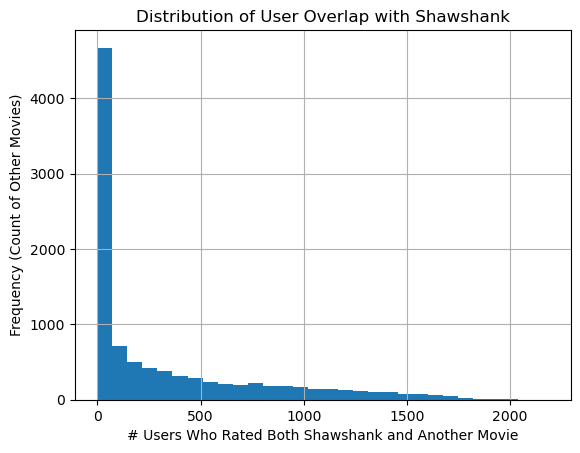

In [15]:
correlated_movies['users_who_rated_both_movies'].hist(bins=30)

plt.xlabel(f"# Users Who Rated Both {movie_title} and Another Movie")
plt.ylabel("Frequency (Count of Other Movies)")
plt.title(f"Distribution of User Overlap with {movie_title}")
plt.show()

Our top movies all appear to have a long tail towards the upper end of the histogram.
<br>
This tells us that most movies have a low overlap of users but some have a very high overlap.

This makes sense. 
<br>
User ratings will tend to have a long-tail pattern because the majority of the interactions occur for a small subset of more popular items.
<br>
In this example, popular movies will have high overlap with other movies (everyone's seen The Shawshank Redemption), while the majority of movies will have low overlap because they are seen by less people and are, therefore, niche and less frequently rated.
<br>
The user-movie matrix is also sparse because because most users only rated a few movies, which contributes to this.

For example, there are <10 other movies that were rated alongside Shawshank by 7000 people. These are probably the most popular movies in the world. 
<br>
There are about 800 movies that were rated alongside Shawshank but ~1300 people. These would be lesser known movies.


Let's try to filter out some of the lower values to concentrate on correlated movies with a higher overlap of users, to get better recommendations.

### Choosing a threshold

We will compare two methods to determine a global threshold, filtering by percentiles and filtering by standard deviation above the mean.


The percentile method will work better if the data is skewed, as in this case, while the mean+std method will work better for normally distributed data, but we will compare them anyway for safety's sake.


We will compare the 90th percentile (top 10%) to mean + 2 std and we will compare the 75th percentile (top 25%) to mean + 1 std.
<br>
The first pairs of thresholds will focus on highly related movies, but after a while our user might have watched all of our recommendations so we may want to lower the threshold.

In [16]:
# Extract overlap values from the movie_correlations_matrix (upper triangle (top half corner), excluding diagonal - the bottom half mirrored on the diagonal are just the same values mirrored)
movie_ids = movie_correlations_matrix.columns
correlation_values = movie_correlations_matrix.values
upper_triangle_indices = np.triu_indices_from(correlation_values, k=1)
correlation_values_flat = correlation_values[upper_triangle_indices]

# Threshold 1: Percentiles
percentile_75 = np.percentile(correlation_values_flat, 75)  # 75th Percentile
percentile_90 = np.percentile(correlation_values_flat, 90)  # 90th Percentile

# Threshold 2: Mean + Standard Deviation
mean_correlation = np.mean(correlation_values_flat)
std_correlation = np.std(correlation_values_flat)
threshold_1_std = mean_correlation + std_correlation  # Mean + 1 Std Dev
threshold_2_std = mean_correlation + 2 * std_correlation  # Mean + 2 Std Dev

# Filter out movies below the thresholds
percentile_75_pairs = correlation_values_flat >= percentile_75
percentile_90_pairs = correlation_values_flat >= percentile_90
mean_1_std_pairs = correlation_values_flat >= threshold_1_std
mean_2_std_pairs = correlation_values_flat >= threshold_2_std

# Reconstruct the filtered pairs into DFs for analysis
percentile_75_df = pd.DataFrame({
    'Movie1': movie_ids[upper_triangle_indices[0]][percentile_75_pairs],
    'Movie2': movie_ids[upper_triangle_indices[1]][percentile_75_pairs],
    'Correlation': correlation_values_flat[percentile_75_pairs]
})

percentile_90_df = pd.DataFrame({
    'Movie1': movie_ids[upper_triangle_indices[0]][percentile_90_pairs],
    'Movie2': movie_ids[upper_triangle_indices[1]][percentile_90_pairs],
    'Correlation': correlation_values_flat[percentile_90_pairs]
})

mean_1_std_df = pd.DataFrame({
    'Movie1': movie_ids[upper_triangle_indices[0]][mean_1_std_pairs],
    'Movie2': movie_ids[upper_triangle_indices[1]][mean_1_std_pairs],
    'Correlation': correlation_values_flat[mean_1_std_pairs]
})

mean_2_std_df = pd.DataFrame({
    'Movie1': movie_ids[upper_triangle_indices[0]][mean_2_std_pairs],
    'Movie2': movie_ids[upper_triangle_indices[1]][mean_2_std_pairs],
    'Correlation': correlation_values_flat[mean_2_std_pairs]
})

# Print summary of results
print(f"Number of pairs (75th Percentile): {len(percentile_75_df)}")
print(f"Number of pairs (90th Percentile): {len(percentile_90_df)}")
print(f"Number of pairs (Mean + 1 Std Dev): {len(mean_1_std_df)}")
print(f"Number of pairs (Mean + 2 Std Dev): {len(mean_2_std_df)}")

Number of pairs (75th Percentile): 45869277
Number of pairs (90th Percentile): 45869277
Number of pairs (Mean + 1 Std Dev): 2086064
Number of pairs (Mean + 2 Std Dev): 1744707


In [22]:
movie_correlations_matrix.shape

(9724, 9724)

In [33]:
percentile_75_movie_correlation_matrix.shape

(9742, 9742)

In [27]:
percentile_75_movie_correlation_matrix = create_movie_correlation_matrix(percentile_75_df, movies)
percentile_75_df.shape

(45869277, 3)

In [28]:
percentile_90_movie_correlation_matrix = create_movie_correlation_matrix(percentile_90_df, movies)
percentile_90_df.shape

(45869277, 3)

In [34]:
percentile_90_movie_correlation_matrix.shape

(9742, 9742)

In [29]:
mean_1_std_movie_correlation_matrix = create_movie_correlation_matrix(mean_1_std_df, movies)
mean_1_std_movie_correlation_matrix.shape

(9742, 9742)

In [30]:
mean_2_std_movie_correlation_matrix = create_movie_correlation_matrix(mean_2_std_df, movies)
mean_2_std_movie_correlation_matrix.shape

(9742, 9742)

In [17]:
percentile_75_df.head()

,Movie1,Movie2,Correlation
0,1,2,0.330978
1,1,3,0.487109
2,1,4,1.000000
3,1,5,0.310971
4,1,6,0.106465


In [18]:
def create_movie_correlation_matrix(df, movies):

    all_movie_ids = movies['movieId'].unique()
    
    # Pivot the df back into a square matrix
    pivot_matrix = df.pivot(index='Movie1', columns='Movie2', values='Correlation')
    # Reindex the matrix to include all the movie_ids, otherwise it won't be symmetric, and fill missing values from the movies which were dropped because they were below the threshold
    pivot_matrix = pivot_matrix.reindex(index=all_movie_ids, columns=all_movie_ids, fill_value=0)
    # Fill additional NaN values
    pivot_matrix = pivot_matrix.fillna(0)
    # Mirror the values across the diagonal to make it symmetric
    pivot_matrix = pivot_matrix + pivot_matrix.T - np.diag(pivot_matrix.values.diagonal())
    
    pivot_matrix = pivot_matrix.rename_axis('movieId', axis='index').rename_axis('movieId', axis='columns')

    return pivot_matrix

def get_top_ten_similar_movies(movie_title, movies, movie_correlations_matrix):
    # Extract the movie ID. 
    movie_title_mask = movies['title'].str.contains(movie_title, case=False)
    movie_id = movies.loc[movie_title_mask, 'movieId'].values[0]
    
    # Extract the correlation values for the movie
    movie_correlations = pd.DataFrame(movie_correlations_matrix[movie_id])
    # Remove the correlation to the movie itself
    movie_correlations = movie_correlations[movie_correlations.index != movie_id]
    # Remove movies with 0 correlation
    movie_correlations = movie_correlations[movie_correlations[movie_id] > 0]
    # Sort the values to get the best correlations
    movie_correlations.sort_values(by=movie_id, ascending=False, inplace=True)
    movie_correlations = movie_correlations.rename(columns={movie_id: movie_title +' - correlation'})
    
    # Get the top ten and add the movie titles
    top_ten = movie_correlations.head(10)
    top_ten.reset_index(inplace=True)
    top_ten = top_ten.merge(movies[['movieId', 'title']], on='movieId', how='left')
    top_ten.set_index('movieId', inplace=True)
    
    return top_ten

def add_num_users_who_rated_both_movies(correlated_movies):
    num_users_who_rated_both_movies = [sum((movie_correlations_matrix[movie_id] > 0) & (movie_correlations_matrix[correlated_movie_id] > 0)) for correlated_movie_id in correlated_movies.index.values]
    correlated_movies['users_who_rated_both_movies'] = num_users_who_rated_both_movies
    return correlated_movies

movie_title = 'Ace Ventura' # 'Shawshank'

In [20]:
percentile_75_movie_correlation_matrix.shape

(9742, 9742)

(9724, 9724)

In [19]:
percentile_75_movie_correlation_matrix = create_movie_correlation_matrix(percentile_75_df, movies)
percentile_75_movie_correlation_matrix = add_num_users_who_rated_both_movies(percentile_75_movie_correlation_matrix)
percentile_75_movie_correlation_matrix

KeyError: 1076

In [ ]:


top_ten_75 = get_top_ten_similar_movies(movie_title, movies, percentile_75_movie_correlation_matrix)
top_ten_75

In [ ]:
percentile_90_movie_correlation_matrix = create_movie_correlation_matrix(percentile_90_df, movies)

top_ten_90 = get_top_ten_similar_movies(movie_title, movies, percentile_90_movie_correlation_matrix)
top_ten_90

In [ ]:
mean_1_std_movie_correlation_matrix = create_movie_correlation_matrix(mean_1_std_df, movies)

top_ten_mean_1_std = get_top_ten_similar_movies(movie_title, movies, mean_1_std_movie_correlation_matrix)
top_ten_mean_1_std

In [ ]:
mean_2_std_movie_correlation_matrix = create_movie_correlation_matrix(mean_2_std_df, movies)

top_ten_mean_2_std = get_top_ten_similar_movies(movie_title, movies, mean_2_std_movie_correlation_matrix)
top_ten_mean_2_std

I checked a few movies and most all had the same recommendations. However, it is worrying that Shawshank, the most rated movie, only has 9 recommendations for the mean+2std threshold.
<br>
This obviously indicates that the threshold is too high.

However, in general, we are not accurately evaluating whether the movies recommended are actually similar.
<br>
To do this we would need to create a manually curated subset of movies which we define as similar and then validate whether the model is returning accurate recommendations by testing the Precision and Recall with the F1 score.
<br>
This is not practical for numerous reasons.

In upcoming steps we will use implement measures to validate our results, such as 
- Comparing the genres of co-rated movies
- Checking if co-rated movies were recommended by the same users
- Perhaps web-scraping some data on the actors and directors to compare whether they are shared by co-rated movies 

For now though, we will examine the sparsity of the matrices for the original recommendations, and with the four thresholds, to see if enough co-rated movies are being suggested for each movie.

In [ ]:
def analyze_recommendations(correlation_matrix):
    """
    Analyze recommendations for a given similarity matrix.
    """
    
    # Set diagonal to zero to exclude self-correlations
    similarity_matrix = correlation_matrix.copy()
    np.fill_diagonal(similarity_matrix.values, 0)

    # Count non-zero recommendations for each movie
    recommendation_counts = (similarity_matrix > 0).sum(axis=1)
    
    # Calculate summary statistics
    stats = {
        'min_recommendations': recommendation_counts.min(),
        'max_recommendations': recommendation_counts.max(),
        'mean_recommendations': recommendation_counts.mean(),
        'median_recommendations': recommendation_counts.median(),
        'movies_with_no_recommendations': (recommendation_counts == 0).sum()
    }
    
    return stats


correlation_matrices = [
    movie_correlations_matrix,
    percentile_75_movie_correlation_matrix,
    percentile_90_movie_correlation_matrix,
    mean_1_std_movie_correlation_matrix,
    mean_2_std_movie_correlation_matrix
]

threshold_labels = [
    'No Threshold',
    '75th Percentile',
    '90th Percentile',
    'Mean + 1 Std Dev',
    'Mean + 2 Std Dev'
]

results = {}
for label, matrix in zip(threshold_labels, correlation_matrices):
    stats = analyze_recommendations(matrix)
    results[label] = stats


results_df = pd.DataFrame(results).T
results_df

For now we will assume that no threshold is necessary, to ensure that all movies get at least some co-rated movies. We can mess around with optimizing the recommendations once we have a more robust way of validating the results.

### Final function

In [ ]:
"""
We will leave the calculation of the Pearson correlation matrix as a separate function 
because it is an intensive calculation and should not be run for each individual movie.

There is no need to sort the values or return the top N similar movies as we will combine
scores with other models later and optimise the weights of the scores for a final result.
"""



def calculate_Pearson_correlation(ratings):
    # Create user-item matrix: 
    user_movie_matrix = pd.pivot_table(data=ratings,
                                       values='rating',
                                       index='userId',
                                       columns='movieId',
                                       fill_value=0)
    
    # Create Pearson correlation matrix
    movie_correlations_matrix = user_movie_matrix.corr()

    return movie_correlations_matrix

def return_Pearson_correlated_movies(movie_id, movie_correlations_matrix):
    # Extract the Pearson correlation values for the movie
    correlated_movies = pd.DataFrame(pearson_correlation_matrix[movie_id])
    # Remove the correlation to the movie itself
    correlated_movies = correlated_movies[correlated_movies.index != movie_id]
    # Rename the column as it will be merged with other scores later.
    correlated_movies.rename(columns={movie_id: 'Pearson_correlation'}, inplace=True)
    return correlated_movies

pearson_correlation_matrix = calculate_Pearson_correlation(ratings)

In [ ]:
movie_title = 'shawshank'
movie_id = get_movie_id_from_title(movie_title, movies)

Pearson_correlated_movies = return_Pearson_correlated_movies(movie_id, pearson_correlation_matrix)
Pearson_correlated_movies.head()

## Cosine Similarity
The **Cosine Similarity** measures the similarity between two vectors based on the cosine of the angle between them. It evaluates whether two vectors point in the same direction in a high-dimensional space, making it a commonly used metric for comparing user or item behavior in recommendation systems.

$$
\text{Cosine Similarity} = \frac{\sum_{i=1}^n A_i \cdot B_i}{\sqrt{\sum_{i=1}^n A_i^2} \cdot \sqrt{\sum_{i=1}^n B_i^2}}
$$

Where:
- $A$ and $B$: Two vectors (e.g., user ratings or movie feature vectors).
- $A_i$, $B_i$: Individual components of the vectors.
- The numerator is the dot product of $A$ and $B$, measuring overlap.
- The denominator is the product of the magnitudes (lengths) of $A$ and $B$, normalizing for vector size.

**How It Works**
1. Cosine similarity measures the **orientation**, not the magnitude, of the vectors.
2. It ranges from **-1** to **1**:
   - **1**: Perfect similarity (vectors point in the same direction).
   - **0**: No similarity (vectors are orthogonal).
   - **-1**: Perfect dissimilarity (vectors point in opposite directions, rarely used in recommendation contexts).

**Key Notes**
- Cosine similarity works well with **sparse data** (e.g., user ratings matrices with many missing values).
- It ignores differences in **magnitude** (e.g., a user who rates all movies 5 stars is treated similarly to one who rates them all 1 star, as long as the relative pattern is the same).
- Missing values are often treated as 0 (no interaction), but this may imply no preference, so alternative handling is sometimes necessary.


In our case we cannot fill the missing values with 0 as this will infer incorrect bad ratings from users.
<br>
Also, due to the extreme sparsity of the data, I do not believe imputing missing values from average ratings is a good idea.
<br>
Therefore, rather than use the typical scikit-learn method, sklearn.metrics.pairwise.cosine_similarity, I will create a mask to filter out sparse values and calculate the cosine similarity for each movie individually.

In [34]:
def calculate_cosine_similarity(ratings):
    
    # Fill NaN with 0 for temporary compatibility
    ratings_filled = ratings_df.fillna(0)
    # Create a mask for shared ratings
    mask = (~ratings_df.isna()).astype(int)
    # Compute the numerator (dot product of shared ratings)
    numerator = (ratings_filled * mask).T @ (ratings_filled * mask)
    # Square the ratings, apply the mask and sum over all users who rated each movie
    magnitudes = np.sqrt((ratings_filled ** 2 * mask).sum(axis=0))
    # Reshape into numpy arrays and perform element-wise multiplication
    denominator = magnitudes.values[:, None] * magnitudes.values[None, :]
    # Compute cosine similarity
    cosine_similarity_matrix = numerator / denominator
    
    return cosine_similarity_matrix

def return_cosine_similar_movies(movie_id, cosine_similarity_matrix):
    # Extract the cosine similarity values for the movie
    similar_movies = pd.DataFrame(cosine_similarity_matrix[movie_id])
    # Remove the similarity to the movie itself
    similar_movies = similar_movies[similar_movies.index != movie_id]
    # Rename the column as it will be merged with other scores later.
    #similar_movies.rename(columns={movie_id: 'Cosine_similarity'}, inplace=True)
    return similar_movies

ratings_df = create_ratings_df(ratings, fill_value=0)
cosine_similarity_matrix = calculate_cosine_similarity(ratings_df)

In [43]:
movie_title = 'shawshank'
movie_id = get_movie_id_from_title(movie_title, movies)

cosine_similar_movies = return_cosine_similar_movies(movie_id, cosine_similarity_matrix)

top_ten = get_top_ten_correlated_movies(cosine_similar_movies, movie_id, movie_title)
top_ten

,shawshank - correlation,title
movieId,,
356,0.712993,Forrest Gump (1994)
296,0.702366,Pulp Fiction (1994)
593,0.647066,"Silence of the Lambs, The (1991)"
50,0.631787,"Usual Suspects, The (1995)"
527,0.629145,Schindler's List (1993)
2959,0.606644,Fight Club (1999)
110,0.597317,Braveheart (1995)
2571,0.589155,"Matrix, The (1999)"
150,0.578835,Apollo 13 (1995)


# User-based filtering

We find other users similar to the user we’re recommending movies to. Then we recommend the movies those other users rated highly.
<br>
Two users will be declared similar if they gave a high (or low) rating to the same movies.

User A loves Fight Club and The Shawshank Redemption and dislikes Love Actually.
<br>
User B loves Fight Club, The Shawshank Redemption, and Taken, and dislikes Love Actually.
<br>
The presumption in this methodology is that Taken would be a good recommendation for User A because User A is similar to User B.